In [1]:
import numpy as np 
import tensorflow as tf 
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
np.random.seed(0)
#Distribution of the training data
class DataDistribution:
    def __init__(self,mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def samples(self, N):
        return np.random.normal(self.mu, self.sigma,N)

In [3]:
def plot_data_distribution():
    distribution = DataDistribution(4,0.5)
    samples = distribution.samples(1000)
    samples = pd.Series(samples)
    samples.plot(kind="density")
    plt.grid(True)
    plt.show()

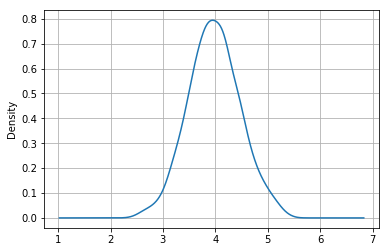

In [4]:
#Plots the density curve of the training data that the generator tries to estimate
plot_data_distribution()

In [5]:
#Noisy signal which serves as an input to the generator
class GeneratorNoiseDistribution:
    def __init__(self,limit):
        self.limit = limit
    def sample_noise(self,N):
        return np.linspace(-self.limit, self.limit,N) + np.random.random() * 0.005

In [6]:
def plot_noise_distribution():
    distribution = GeneratorNoiseDistribution(4)
    samples = distribution.sample_noise(1000)
    samples = pd.Series(samples)
    samples.plot(kind = "density")
    plt.grid(True)
    plt.show()

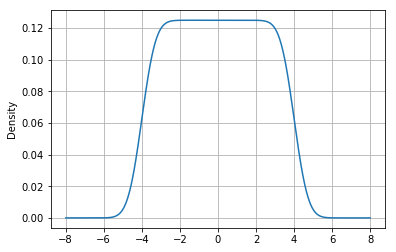

In [7]:
plot_noise_distribution()

In [8]:
class Model:
    def __init__(self):
        pass
    def new_weights(self, shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev = 0.05), name = name)
    def new_biases(self, length, name):
        return tf.Variable(tf.constant(0.5, shape = [length]), name = name)
    def linear(self, data_input,weights, biases):
        return tf.matmul(data_input, weights) + biases

In [9]:
class Generator(Model):
    def __init__(self,num_input_neurons,num_hidden_neurons,num_output_neurons):
       
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons
    def get_output(self,x):
        w1 = self.new_weights([self.num_input_neurons,self.num_hidden_neurons],"w1")
        b1 = self.new_biases(self.num_hidden_neurons,"b1")
        w2 = self.new_weights([self.num_hidden_neurons, self.num_output_neurons],"w2")
        b2 = self.new_biases(self.num_output_neurons,"b2")
        
        layer_1 = tf.nn.softplus(self.linear(x, w1, b1))
        layer_2 = self.linear(layer_1,w2,b2)
        return layer_2
        
        

In [16]:
class Discriminator(Model):
    def __init__(self,num_input_neurons,num_hidden_neurons,num_output_neurons):
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons
    def get_output(self,x):
        w1 = self.new_weights([self.num_input_neurons,self.num_hidden_neurons],"w1")
        b1 = self.new_biases(self.num_hidden_neurons,"b1")
        w2 = self.new_weights([self.num_hidden_neurons, self.num_hidden_neurons],"w2")
        b2 = self.new_biases(self.num_hidden_neurons,"b2")
        w3 = self.new_weights([self.num_hidden_neurons, self.num_hidden_neurons],"w3")
        b3 = self.new_biases(self.num_hidden_neurons,"b3")
        w4 = self.new_weights([self.num_hidden_neurons, self.num_output_neurons],"w4")
        b4 = self.new_biases(self.num_output_neurons,"b4")
        
        
        layer_1 = tf.nn.relu(self.linear(x, w1, b1))
        layer_2 = tf.nn.relu(self.linear(layer_1,w2,b2))
        layer_3 = tf.nn.relu(self.linear(layer_2,w3,b3))
        layer_4 = tf.nn.sigmoid(self.linear(layer_3,w4,b4))
        return layer_4

In [17]:

G = Generator(1,200,1)
D = Discriminator(1,200,1)
x_g = tf.placeholder(tf.float32, [None,1])
x_d = tf.placeholder(tf.float32, [None,1])
g_output = G.get_output(x_g)
d_output_true = D.get_output(x_d)
d_output_fake = D.get_output(g_output)
loss_d = tf.reduce_mean(-tf.log(d_output_true) - tf.log(1 - d_output_fake))
loss_g = tf.reduce_mean(-tf.log(d_output_fake))

In [18]:
train_d = tf.train.AdamOptimizer(0.001).minimize(loss_d)
train_g = tf.train.AdamOptimizer(0.001).minimize(loss_g)

In [19]:
epoch = 1000
batch_size = 100
session = tf.Session()
def optimize(epoch, batch_size):
    for i in xrange(epoch):
        session.run(tf.global_variables_initializer())
        data_source = DataDistribution(4,0.5)
        generator_noise = GeneratorNoiseDistribution(4.5)
        d_input = data_source.samples(batch_size).reshape((-1,1))
        z_noise = generator_noise.sample_noise(batch_size).reshape((-1,1))
            
        session.run(train_d, { x_d: d_input,
                                   x_g: z_noise})
        z_noise = generator_noise.sample_noise(batch_size).reshape((-1,1))
        session.run(train_g, {x_g: z_noise})
        loss_discriminator, loss_generator = session.run([loss_d, loss_g], {
                                                x_d: d_input,
                                                x_g: z_noise})
        print "Epoch: {},Discriminator Loss: {}, Generator Loss: {}".format(i, loss_discriminator, loss_generator)
            
            
    test_output = session.run(g_output,{x_g: generator_noise.sample_noise(batch_size).reshape((-1,1))})
    return test_output

In [ ]:
g = optimize(epoch,batch_size)

Epoch: 0,Discriminator Loss: 1.0830501318, Generator Loss: 0.471898198128
Epoch: 1,Discriminator Loss: 0.979772031307, Generator Loss: 0.604965388775
Epoch: 2,Discriminator Loss: 1.13124358654, Generator Loss: 0.426376879215
Epoch: 3,Discriminator Loss: 0.613359928131, Generator Loss: 1.08921325207
Epoch: 4,Discriminator Loss: 0.961463093758, Generator Loss: 0.557771921158
Epoch: 5,Discriminator Loss: 1.29729557037, Generator Loss: 0.4396083951
Epoch: 6,Discriminator Loss: 1.37537992001, Generator Loss: 0.344242095947
Epoch: 7,Discriminator Loss: 1.36539065838, Generator Loss: 0.371448516846
Epoch: 8,Discriminator Loss: 1.40150308609, Generator Loss: 0.333884268999
Epoch: 9,Discriminator Loss: 0.919135034084, Generator Loss: 0.57909822464
Epoch: 10,Discriminator Loss: 1.3329449892, Generator Loss: 0.376268804073
Epoch: 11,Discriminator Loss: 1.1958770752, Generator Loss: 0.4531686306
Epoch: 12,Discriminator Loss: 1.407751441, Generator Loss: 0.327872008085
Epoch: 13,Discriminator Loss:

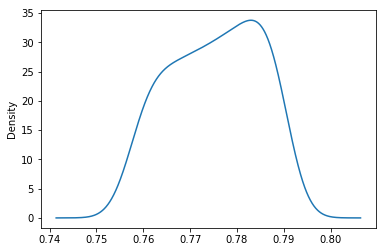

In [15]:
g = pd.Series(g.ravel())
g.plot(kind = "density")
plt.show()
session.close()